# Calculate dissimilarity of molecular and crystal structures

**Instruction**  
This notebook aims to compare the dissimilarity of molecular and crystal structures. The execution of the following code requires the file `chiral-racemic-pairs_cleaned.csv`.  
  
**Contents**  
1. Check Wallach's rule in our dataset 
1. Calculate the dissiilarity of molecular structures using Mordred descriptors
1. Download cif files (This requires CSD lisence.)
1. Calculate the dissiilarity of crystal structures using SOAP kernel

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE,MDS
from rdkit import Chem
import glob
from dscribe.descriptors import SOAP
import pathlib, os
import ccdc
from ase import io
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [28]:
df = pd.read_csv('./dataset/chiral-racemic-pairs_cleaned.csv', index_col=0)
print(df.shape)
df.head(2)

(2899, 7)


,SMILES,refcode,spacegroup,density,temperature,pressure,label
0,O=C(O)c1ccc(Cn2cnc3ccccc32)cc1,ABADIS,P21/c,1.358,293.0,NaN,racemic
1,O=C(O)c1ccc(Cn2cnc3ccccc32)cc1,ABADIS01,P212121,1.320,293.0,NaN,chiral


## 1. Check Wallach's rule

In [29]:
unique_smiles = set(list(df['SMILES']))
print('All rows: ', df.shape[0])
print('Unique smiles: ', len(unique_smiles))

All rows:  2899
Unique smiles:  1356


In [19]:
# Pickup each pair of chiral and racemic crystals, and calculate difference
counted_smiles = []
multicount_smiles = []
diff_list = []
anti_wallach = []
for smiles in unique_smiles:
    df_pickup = df[df['SMILES']==smiles].reset_index()
    if df_pickup.shape[0]==2:
        if abs(df_pickup['temperature'][0] - df_pickup['temperature'][1]) <= 20:
            diff = df_pickup['density'][0] - df_pickup['density'][1] # rac-chiral
            diff_list.append(diff)
            counted_smiles.append(smiles)
    elif df_pickup.shape[0]>=3:
        multicount_smiles.append(smiles)
print(len(counted_smiles))
print(len(multicount_smiles))

832
148


Text(0.5, 0, '${\\Delta}d_{racemic-chiral}$ (g/cm$^3$)')

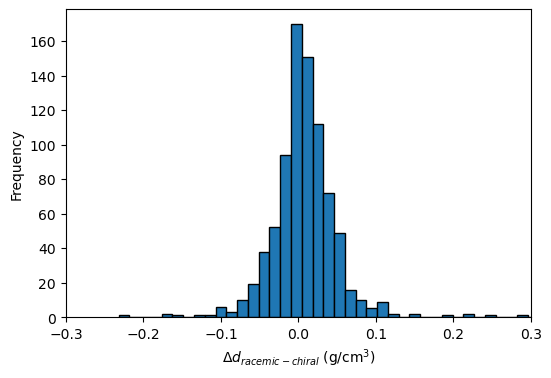

In [20]:
plt.figure(figsize=(6,4))
plt.hist(diff_list, bins=80, ec='k')
plt.xlim(-0.3, 0.3)
plt.ylabel('Frequency')
plt.xlabel(r'${\Delta}d_{racemic-chiral}$ (g/cm$^3$)')

In [10]:
np.mean(diff_list)

0.008550480769230765

In [11]:
np.median(diff_list)

0.006000000000000005

## 2. Calculate the dissimilarity of molecular structures

In [30]:
counted_smiles.append('C[C@H](/N=C/C1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1O)C2=C3C(C=CC=C3)=CC=C2')
counted_smiles.append('C[C@H](/N=C/C1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1O)C2=CC3=CC=CC=C3C=C2')

In [31]:
len(set(counted_smiles))

834

In [32]:
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smiles) for smiles in counted_smiles]
X = calc.pandas(mols, quiet=True)
X = X.dropna(axis=1)
X_save = X.select_dtypes('number')
X = StandardScaler().fit_transform(X_save)

C:\Users\s0928\anaconda3\envs\wallach2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\s0928\anaconda3\envs\wallach2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\s0928\anaconda3\envs\wallach2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\s0928\anaconda3\envs\wallach2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\s0928\anaconda3\envs\wallach2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\s0928\anaconda3\envs\walla

In [33]:
X.shape

(836, 817)

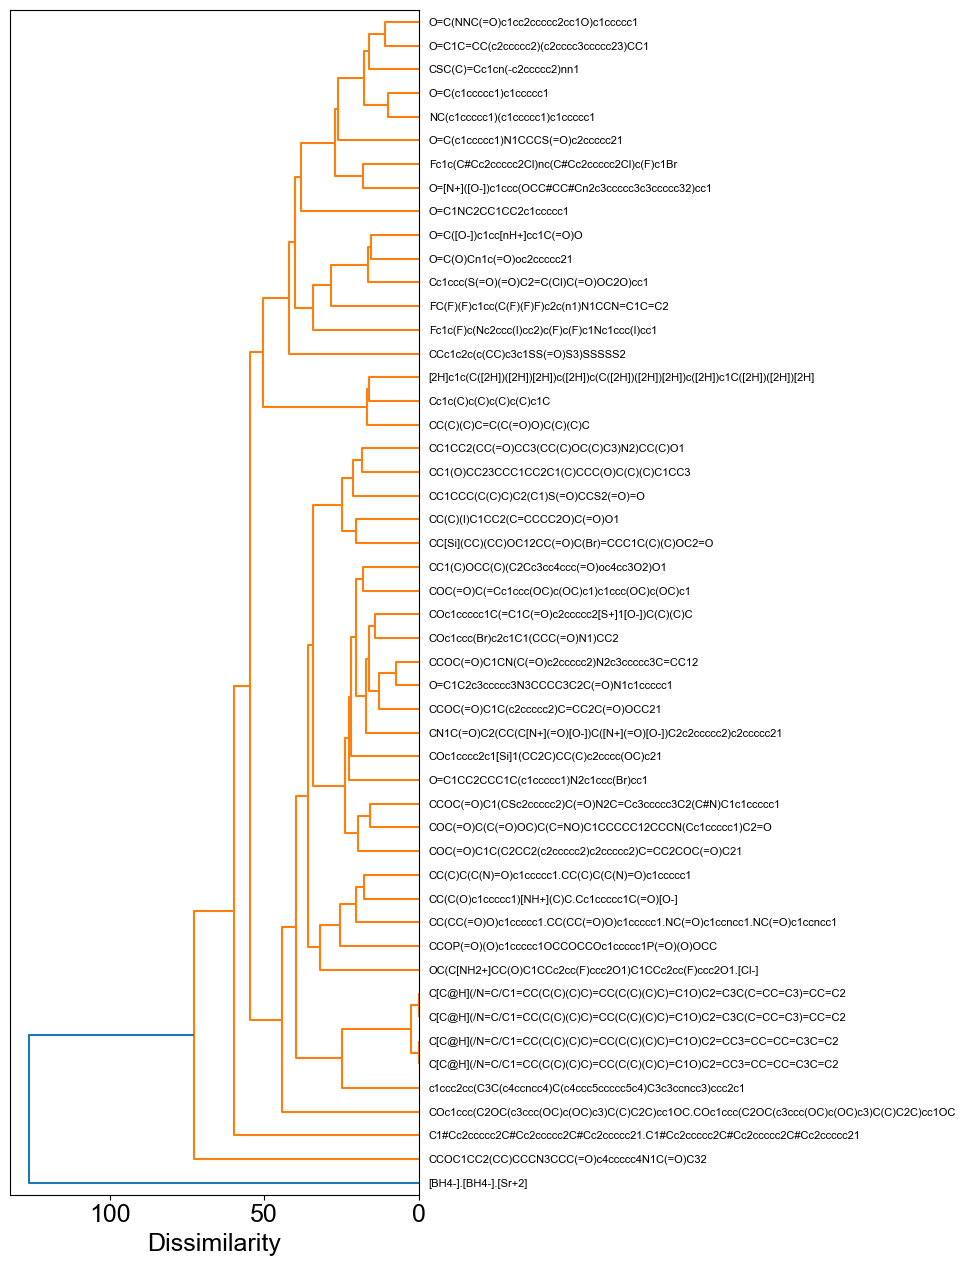

In [34]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

# Clustering by eulidean distance and ward method
z = linkage(X[-50:], metric='euclidean', method='ward')

# Visualize
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(10,13), facecolor="w", edgecolor=None)
ax = fig.add_subplot(1, 1, 1)
dendro = dendrogram(z, distance_sort=True, orientation='left', truncate_mode=None, labels=counted_smiles[-50:])
plt.xlabel('Dissimilarity')
plt.tight_layout()
# plt.savefig('./figures/ccdc_chiral racemic_dendrogram.png', dpi=300)

In [132]:
# z contains index pairs sorted by distance
z = linkage(X[:], metric='euclidean', method='ward')

In [131]:
# Visualize (Save) molecules
smiles_list = []
idx = 1
smiles_list.append(counted_smiles[int(z[idx][0])])
smiles_list.append(counted_smiles[int(z[idx][1])])
smiles_list = sorted(smiles_list, key=len)
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
img = Chem.Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300,300), useSVG=True)
with open(f'figures/mol-pair_{idx}_test.svg', mode='w') as f:
    f.write(img.data)

## 3. Download cif files

In [35]:
df_rev = df[df['SMILES'].isin(counted_smiles)]
df_rev_chiral = df_rev[df_rev['label']=='chiral']
df_rev_racemic = df_rev[df_rev['label']=='racemic']

In [37]:
## Download cif file to a local folder
entry_reader = ccdc.io.EntryReader('CSD')

def ref2cif(reflist, path):
    os.makedirs(path, exist_ok=True)
    exclude_list = []
    for ref in reflist:
        x = entry_reader.entry(ref)
        if x.has_3d_structure is True:
            x = x.crystal.to_string(format='cif')
            cif = pathlib.Path(path+ref+'.cif')
            cif.touch()
            cif = open(path+ref+'.cif', 'w', encoding='utf_8')
            cif.write(x)
            cif.close
        else:
            exclude_list.append(ref)
    return exclude_list

In [38]:
exclude_chiral = ref2cif(df_rev_chiral['refcode'], './cifs_chiral/')

In [39]:
exclude_racemic = ref2cif(df_rev_racemic['refcode'], './cifs_racemic/')

In [41]:
print(len(exclude_chiral))
print(len(exclude_racemic))

0
14


In [42]:
del_list = []
for ref in exclude_racemic:
    del_tmp = df_rev[df_rev['SMILES']==df_rev[df_rev['refcode']==ref]['SMILES'].iloc[-1]]
    del_list.append(del_tmp[del_tmp['label']=='chiral']['refcode'].iloc[-1])
print(del_list)

['BIKHIN01', 'CUNKAY01', 'XUYJOQ', 'DAPSUO11', 'HIVBOE', 'LUHCAS', 'RUHCIG01', 'SOPLAL', 'TGLYBE02', 'TGLYSU21', 'UYAPAM', 'WUQLAW', 'XOKMOZ01', 'XUYKEH']


### [Notice]
Please delete or move the above cifs manually from the download folder.

## 4. Calculate the dissimilarity of crystal structures using SOAP kernel
### [Notice]
Please install Dscribe first, otherwise older version of Dscribe will be installed, and it will cause error when execution.
1. Install Dscribe (https://singroup.github.io/dscribe/latest/install.html)
1. Install CSD python API (https://downloads.ccdc.cam.ac.uk/documentation/API/)
1. Install mordred (& rdkit) (http://mordred-descriptor.github.io/documentation/master/)
1. Install Jupyterlab if you need

In [25]:
species = ['H', 'C', 'O', 'N', 'F', 'Br', 'Cl', 'I', 'F', 'Mn', 'S', 'P', 'B', 'Ca', 'Na', 'Sr', 'Si', 'Se', 'As', 'Be']
r_cut = 8.0
n_max = 8
l_max = 6

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    sparse=False,
    average="inner",
    rbf="gto",
    crossover=False,
)

In [74]:
cifs_chiral = glob.glob('./cifs_chiral/*.cif')
cifs_racemic = glob.glob('./cifs_racemic/*.cif')

# List of filenames with extensions removed
cifs_chiral = [os.path.splitext(os.path.basename(path))[0] for path in cifs_chiral]
cifs_racemic = [os.path.splitext(os.path.basename(path))[0] for path in cifs_racemic]

# Sort the elements of List in the order of List2
list2 = list(df_rev_chiral['refcode'])
sorted_cifs_chiral = sorted(cifs_chiral, key=lambda x: list2.index(x) if x in list2 else len(list2))
list2 = list(df_rev_racemic['refcode'])
sorted_cifs_racemic = sorted(cifs_racemic, key=lambda x: list2.index(x) if x in list2 else len(list2))

In [37]:
features_chiral = [soap.create(io.read(f'./cifs_chiral/{data}.cif')) for data in sorted_cifs_chiral]
features_racemic = [soap.create(io.read(f'./cifs_racemic/{data}.cif')) for data in sorted_cifs_racemic]

In [38]:
print(len(features_chiral))
print(len(features_racemic))

818
818


### 4.1 Global dissimilarity

In [39]:
import numpy as np
dist_list = []
for i in range(len(features_chiral)):
    dist = np.linalg.norm(features_chiral[i]-features_racemic[i])
    dist_list.append(dist)

In [40]:
print(max(dist_list))
print(dist_list.index(max(dist_list)))

90071.65905324892
206


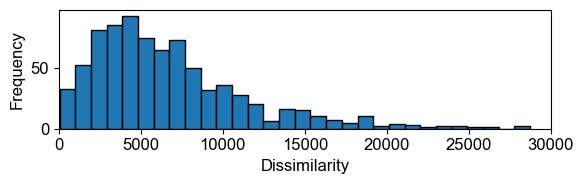

In [43]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(6,2))
lim = 30000
plt.hist(np.array(dist_list)[np.array(dist_list)<lim], bins=30, ec='k') #[np.array(dist_list)<20000]
plt.xlim(0,lim)
plt.xlabel('Dissimilarity')
plt.ylabel('Frequency')
plt.tight_layout()
# plt.savefig('./figures/Cryst_dissimilarity_all.png', dpi=300)

### 4.2 Local dissimilarity of chiral-racemic crystals of two analogs

In [61]:
cifs_sa = glob.glob('./SA/*20*.cif')
cifs_sa = [os.path.splitext(os.path.basename(path))[0] for path in cifs_sa]
cifs_sa

['Structure_rac-1_20_major',
 'Structure_rac-2_20_major',
 'Structure_S-1_-20_major',
 'Structure_S-1_20_major',
 'Structure_S-1_20_major_Ishizaki',
 'Structure_S-2_20_major']

In [71]:
from scipy.spatial import distance
idx = [0,1,3,5]
features_sa = [soap.create(io.read(f'./SA/{data}.cif')) for i, data in enumerate(cifs_sa) if i in idx]
dist_sa = distance.cdist(features_sa, features_sa, metric='euclidean')

In [72]:
plt.rcParams["font.family"] = "Arial"
def draw_heatmap(data, row_labels, column_labels):
    fig, ax = plt.subplots(figsize=(5,4))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8)
    for i in np.arange(data.shape[0]):
        for j in np.arange(data.shape[1]):
            ax.text(i+0.5, j+0.58, int(np.round(data[i,j])), ha='center')

    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)
    fig.colorbar(heatmap, ax=ax, label='Dissimilarity', orientation='vertical')
    # fig.savefig('./figures/heatmap_1.png', dpi=300)
    plt.show()
    
    return heatmap

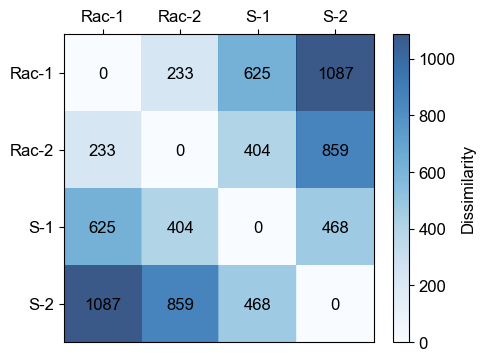

In [73]:
labels = ['Rac-1', 'Rac-2', 'S-1', 'S-2']
draw_heatmap(dist_sa, labels, labels)